In [1]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

loo = LeaveOneOut()
lr = linear_model.LinearRegression()
lasso = linear_model.Lasso()

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Arial']})
import seaborn as sns
import json
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [3]:
#filter out nan from list
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list


def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

In [4]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# load all data from csvs stored in the repo

#ALLEN INSTITUTE CELL FEATURE METADATA
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)


#GENE EXPRESSION DATA
#transcriptomic gene expression data by cell type including layers (gene number x cre-line w/ layers)
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)


#ION CONDUCTANCE DATA
#relative conductance data for cell types separated by layers (cre-line w/ layers x parameters)
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)


#VGIC LIST
#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)


#SPEARMAN CORRELATION RANKS
#Spearman Correlation ranks for cell types and relative conductance
f = open("new_sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()



#BASIC METADATA
#cre line basic metadata, including subclasses, colours
cre_line_metadata = pd.read_csv("data/cre_line_info.csv", index_col=0)


#CSV file containing list of names, colours for corresponding cre-line, related VGIC to conductance parameter
org = pd.read_csv("org.csv", index_col=0)

#Parameter names
parameters = list(org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = filter_out_nan(list(org['shared']))

#Dictionary of the related genes to the 6 parameters
related_RNA = {}
for para in shared_parameters:
    related_RNA[para] = filter_out_nan(list(org[para]))

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)
gene_channel_vgic = ion_channel_genes.loc["vgic"]

#List of gene channels that have expression of more than .1
exclude = [] #filter out gene expression less than .1
for gene in list(gene_channel_vgic['Mouse Entrez Gene']):
    if int(gene) in list(transcriptome_df.index):
        if sum(list(transcriptome_df.loc[int(gene)]))/len(list(transcriptome_df.loc[int(gene)])) < .1:
            exclude.append(gene)
for excluded_gene in exclude:
    gene_channel_vgic_filtered = gene_channel_vgic[gene_channel_vgic['Mouse Entrez Gene'] != excluded_gene]

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))
cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
#Set-up for palette for cell types based on shortened Cre-line name
shortened_color = filter_out_nan(list(org['short']))
shortened_palette = palette_builder(shortened_color, list(org['colour']))
#Set-up for palette for cell types based on class
color_inh = filter_out_nan(list(cre_line_metadata['class_colour']))
#Set-up for palette for cell types based on subclass
color_sub = filter_out_nan(list(cre_line_metadata['subclass_colour']))
class_inh = filter_out_nan(list(cre_line_metadata['class']))
subclasses = filter_out_nan(list(cre_line_metadata['subclass']))

In [5]:
#calculate the standard deviation and sem
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

#set sem and std to the values for standard deviation and sem for relative
sem, std = cal_std_sem(parameters)


In [6]:
#HELPER FUNCTIONS
#creating the data for specific ion parameter of cre-lines
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

#creating the data for specific gene expression of cre-lines
def create_gene_spec_filtered(gene_symbol):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    return gene_spec_filtered, gene_id

#function for renaming into shortened cre-line
def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)
    
    
#creating ion parameter x gene expression matrix
def create_graph_spec(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec(graph_spec)
    
    return graph_spec

In [7]:
def graph_pred(x_pred, y_pred, cond, cv_type=lr, show_best_line=True, show_score=True):
    X = np.array(x_pred)
    y = np.array(y_pred)
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    LeaveOneOut()
    y_true, predicted = list(), list()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LinearRegression()
        model.fit(X_train, y_train)
        # evaluate model
        yhat = model.predict(X_test)
        # store
        y_true.append(y_test[0])
        predicted.append(yhat[0])
    # calculate accuracy
    
    # predicted = cross_val_predict(cv_type, x_pred, y_pred, cv=15)

    # best fit line
    if(show_best_line):
        fit = np.polyfit(y_true, predicted, deg = 1)
    
    ax = plt
    ax.scatter(y_true, predicted, s = 100, alpha = 0.3, marker = 'o', c=list(shortened_palette.values()))
    
#     if(show_score):
#         if (cv_type==lasso):
#             reg = Lasso().fit(x_pred, y_pred)
#             r2 = reg.score(x_pred, y_pred)
#         else:
#             reg = LinearRegression().fit(x_pred, y_pred)
#             r2 = round(reg.score(x_pred, y_pred), 2)
    r2 = round(r2_score(y_true, predicted), 2)
    border = (max(y_true) - min(y_true))*(1/20)
    ax.text(x=(max(y_true)-border*6), y=(min(y_true)+border), s="$R^2_{LOOCV}$ = " + "{}".format(r2), fontsize = 15)
    
    ax.xlim(min(y_true)-border, max(y_true)+border)
    ax.ylim(min(y_true)-border, max(y_true)+border)

    #Setting axis labels
    ax.xlabel('Measured {} Conductance'.format(cond))
    ax.ylabel('Predicted {} Conductance'.format(cond))
    
    
    lim = pd.Series([min(y_true), max(y_true)])
    
    ax.plot(lim, lim * fit[0] + fit[1], 'k-', linewidth = 1)
        
    ax.tick_params(axis = 'both', length=0, width=0)
    ax.gca().set_aspect('equal', adjustable='box')
    
    return ax

In [8]:
graph_spec = create_graph_spec("gbar_Kv3_1", "Kcnc1", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_Kv3_1", "Kcnc2", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_Kv3_1", "Kcnc3", sep_layer_cre_parameter_df)
graph_spec4 = create_graph_spec("gbar_Kv3_1", "Kcnc4", sep_layer_cre_parameter_df)

y_Kv3_1 = list(graph_spec['gbar_Kv3_1'])
x1 = list(graph_spec[16502])
x2 = list(graph_spec2[268345])
x3 = list(graph_spec3[16504])
x4 = list(graph_spec4[99738])

X_Kv3_1 = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i], x4[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_Kv3_1.append(new_list)
    i += 1


In [9]:
graph_spec = create_graph_spec("gbar_K_T", "Kcnd1", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_K_T", "Kcnd2", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_K_T", "Kcnd3", sep_layer_cre_parameter_df)

y_KT = list(graph_spec['gbar_K_T'])
x1 = list(graph_spec[16506])
x2 = list(graph_spec2[16508])
x3 = list(graph_spec3[56543])

X_KT = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_KT.append(new_list)
    i += 1

In [10]:
graph_spec = create_graph_spec("gbar_SK", "Kcnn1", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_SK", "Kcnn2", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_SK", "Kcnn3", sep_layer_cre_parameter_df)

y_SK = list(graph_spec['gbar_SK'])
x1 = list(graph_spec[84036])
x2 = list(graph_spec2[140492])
x3 = list(graph_spec3[140493])

X_SK = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_SK.append(new_list)
    i += 1

In [11]:
graph_spec = create_graph_spec("gbar_Ih", "Hcn1", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_Ih", "Hcn2", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_Ih", "Hcn3", sep_layer_cre_parameter_df)
graph_spec4 = create_graph_spec("gbar_Ih", "Hcn4", sep_layer_cre_parameter_df)

y_Ih = list(graph_spec['gbar_Ih'])
x1 = list(graph_spec[15165])
x2 = list(graph_spec2[15166])
x3 = list(graph_spec3[15168])
x4 = list(graph_spec4[330953])

X_Ih = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i], x4[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_Ih.append(new_list)
    i += 1

In [12]:
graph_spec = create_graph_spec("gbar_Ca_HVA", "Cacna1a", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_Ca_HVA", "Cacna1b", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_Ca_HVA", "Cacna1c", sep_layer_cre_parameter_df)
graph_spec4 = create_graph_spec("gbar_Ca_HVA", "Cacna1d", sep_layer_cre_parameter_df)
graph_spec5 = create_graph_spec("gbar_Ca_HVA", "Cacna1f", sep_layer_cre_parameter_df)
graph_spec6 = create_graph_spec("gbar_Ca_HVA", "Cacna1s", sep_layer_cre_parameter_df)

y_Ca_HVA = list(graph_spec['gbar_Ca_HVA'])
x1 = list(graph_spec[12286])
x2 = list(graph_spec2[12287])
x3 = list(graph_spec3[12288])
x4 = list(graph_spec4[12289])
x5 = list(graph_spec5[54652])
x6 = list(graph_spec6[12292])

X_Ca_HVA = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i], x4[i], x5[i], x6[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_Ca_HVA.append(new_list)
    i += 1

In [13]:
graph_spec = create_graph_spec("gbar_Ca_LVA", "Cacna1g", sep_layer_cre_parameter_df)
graph_spec2 = create_graph_spec("gbar_Ca_LVA", "Cacna1h", sep_layer_cre_parameter_df)
graph_spec3 = create_graph_spec("gbar_Ca_LVA", "Cacna1i", sep_layer_cre_parameter_df)

y_Ca_LVA = list(graph_spec['gbar_Ca_LVA'])
x1 = list(graph_spec[12291])
x2 = list(graph_spec2[58226])
x3 = list(graph_spec3[239556])

X_Ca_LVA = []
i=0
for cells in x1:
    new_list = [x1[i], x2[i], x3[i]]
    # new_list = [x1[i], x2[i], x3[i]]
    X_Ca_LVA.append(new_list)
    i += 1

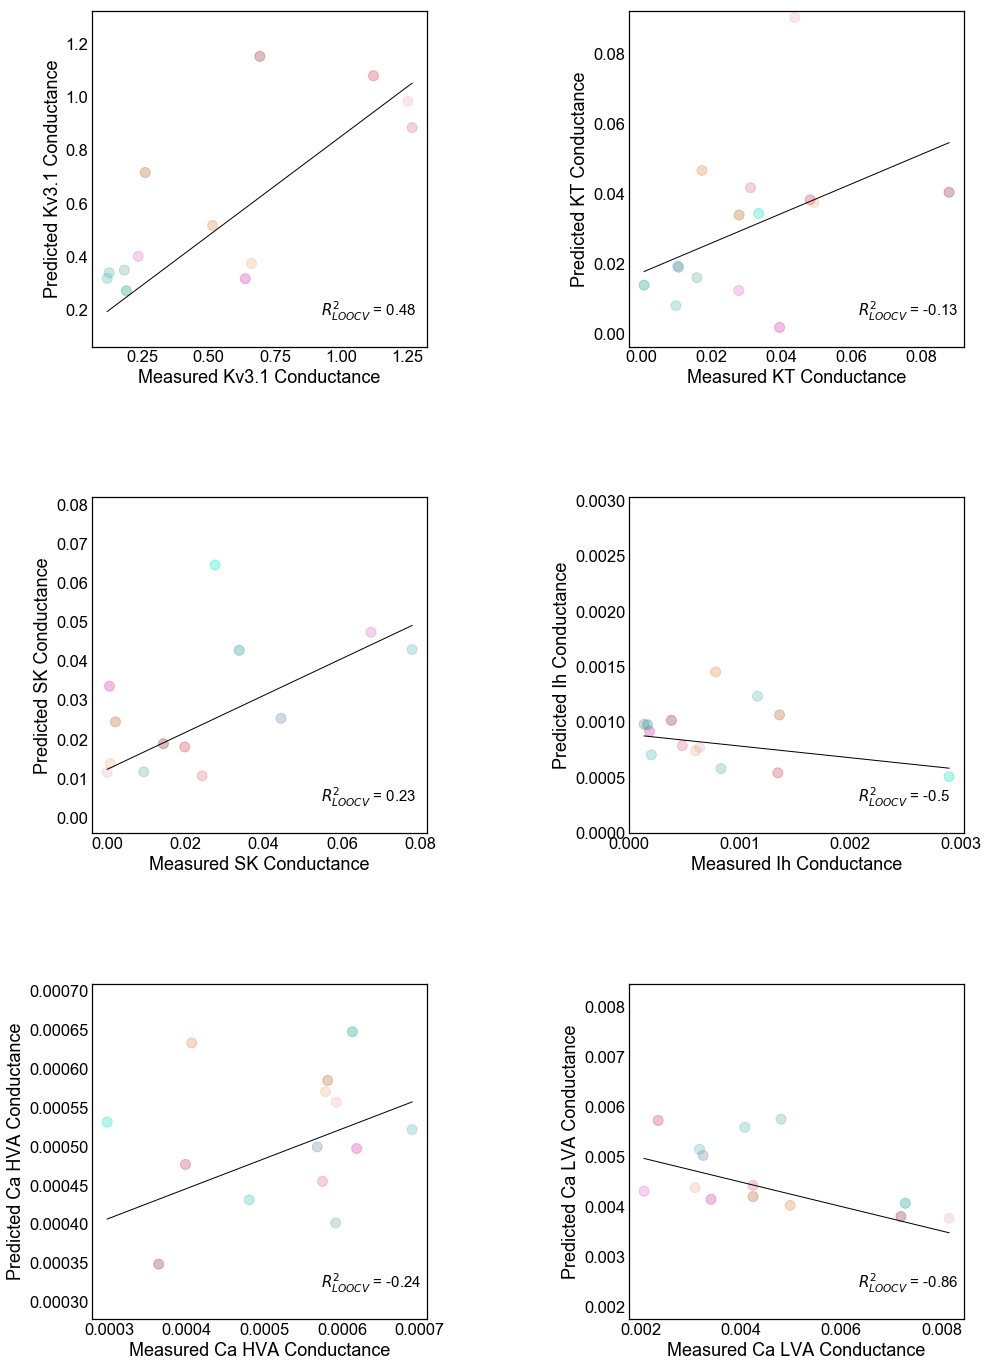

In [19]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 2
nrows = 3
fig = plt.figure(figsize = (14,14))
fig.set_figheight(23)
fig.set_figwidth(15)

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_pred(X_Kv3_1, y_Kv3_1, "Kv3.1")

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_pred(X_KT, y_KT, "KT")

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_pred(X_SK, y_SK, "SK")

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_pred(X_Ih, y_Ih, "Ih")

ax5 = fig.add_subplot(grid[2, 0])
ax5 = graph_pred(X_Ca_HVA, y_Ca_HVA, "Ca HVA")

ax6 = fig.add_subplot(grid[2, 1])
ax6 = graph_pred(X_Ca_LVA, y_Ca_LVA, "Ca LVA")

fig.savefig('figures/leave_one_out.svg', transparent=True)

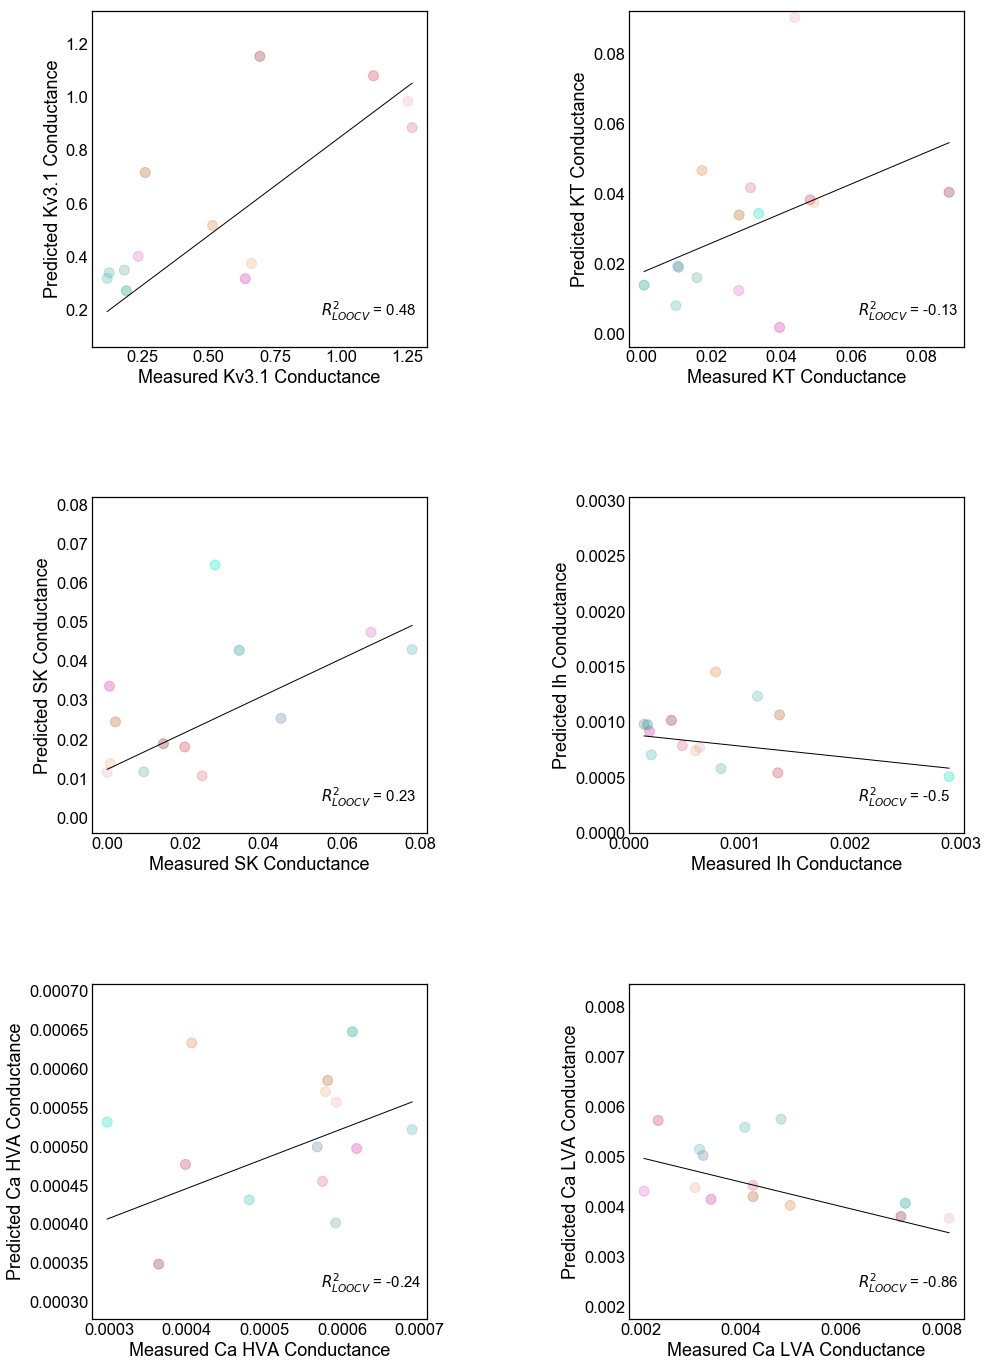

In [15]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 2
nrows = 3
fig = plt.figure(figsize = (14,14))
fig.set_figheight(23)
fig.set_figwidth(15)

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_pred(X_Kv3_1, y_Kv3_1, "Kv3.1")

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_pred(X_KT, y_KT, "KT")

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_pred(X_SK, y_SK, "SK")

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_pred(X_Ih, y_Ih, "Ih")

ax5 = fig.add_subplot(grid[2, 0])
ax5 = graph_pred(X_Ca_HVA, y_Ca_HVA, "Ca HVA")

ax6 = fig.add_subplot(grid[2, 1])
ax6 = graph_pred(X_Ca_LVA, y_Ca_LVA, "Ca LVA")

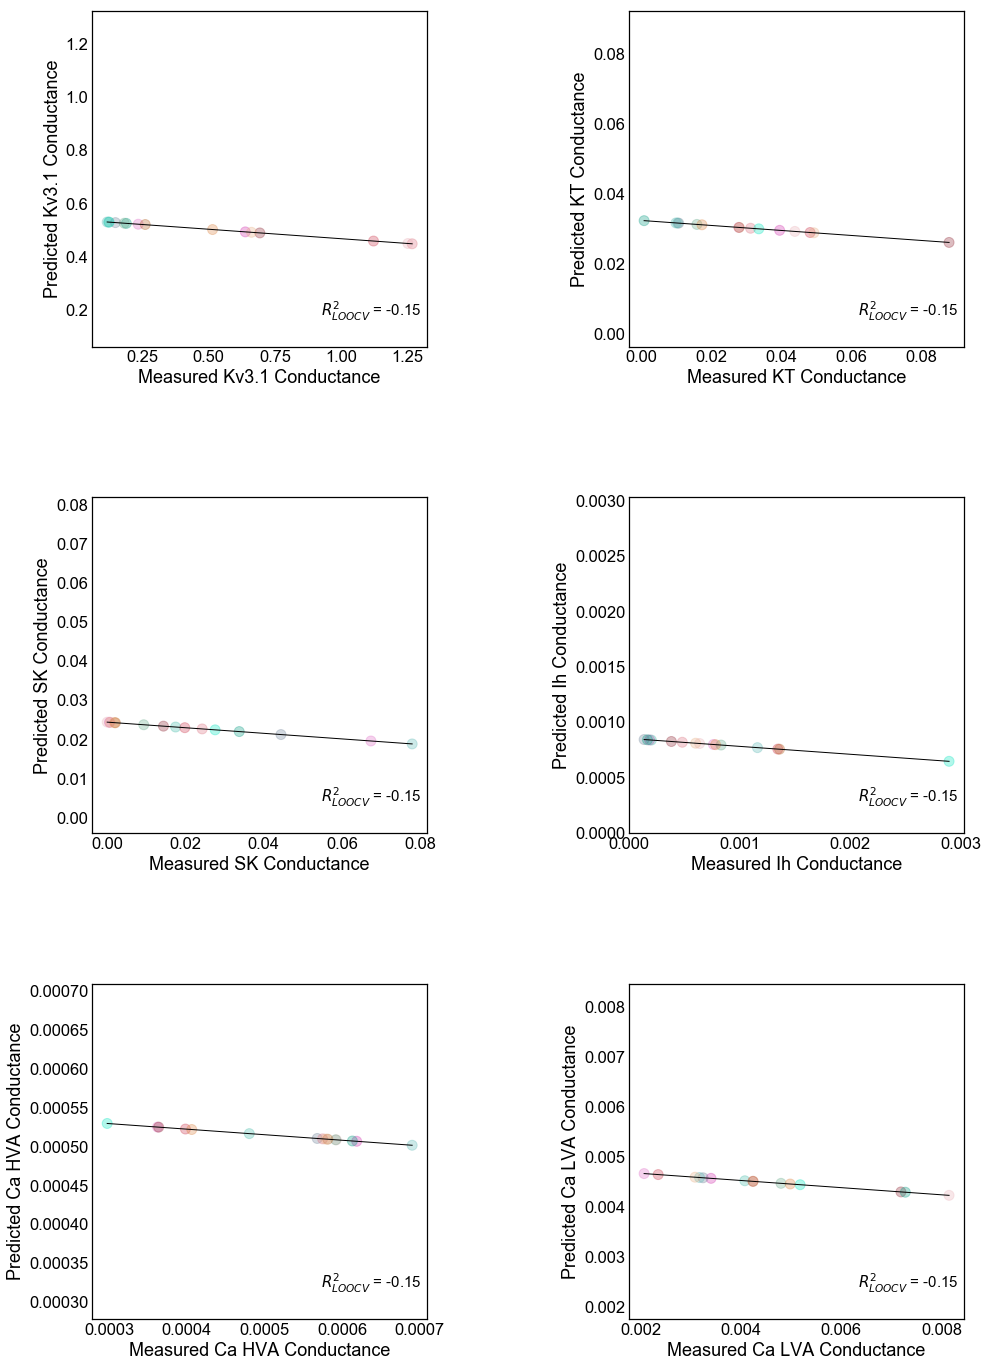

In [31]:
# Initialize the grid with 3 rows and 3 columns
ncols = 2
nrows = 3
fig = plt.figure(figsize = (14,14))
fig.set_figheight(23)
fig.set_figwidth(15)


grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_pred(X_Kv3_1, y_Kv3_1, "Kv3.1", cv_type=lasso)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_pred(X_KT, y_KT, "KT", cv_type=lasso)

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_pred(X_SK, y_SK, "SK", cv_type=lasso)

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_pred(X_Ih, y_Ih, "Ih", cv_type=lasso)

ax5 = fig.add_subplot(grid[2, 0])
ax5 = graph_pred(X_Ca_HVA, y_Ca_HVA, "Ca HVA", cv_type=lasso)

ax6 = fig.add_subplot(grid[2, 1])
ax6 = graph_pred(X_Ca_LVA, y_Ca_LVA, "Ca LVA", cv_type=lasso)

[[6.46228828501, 4.48858408801, 1.75188289863, 1.76892531757], [6.628301790669999, 6.41041761717, 2.46571885772, 1.91554669436], [4.253329127280002, 5.94837034988, 3.40366569493, 4.941209304659999], [2.23916829986, 0.332700191957, 2.03184643277, 5.41303703258], [9.53932698169, 9.45476345477, 5.594949473890001, 0.132122942959], [9.61021556078, 9.77857597467, 6.09078534822, 0.367600150127], [9.321004914249999, 10.153406795, 5.1826016658, 0.57504044448], [9.39544885515, 10.6920919338, 5.94061087283, 1.00831388557], [4.34595505253, 5.25113059339, 2.8136427543, 5.44191889704], [2.21452020823, 3.00301611214, 2.54656000539, 4.88452308953], [4.064034122230002, 5.38314993704, 2.95618131015, 6.33285915952], [4.25851256418, 6.24732656735, 3.51779145584, 4.91696007645], [7.79761116541, 7.95938400719, 3.10472971776, 1.06099982166], [7.1206281114, 8.63346487421, 2.70016199394, 4.40817896761], [7.005162286939999, 9.505379565639998, 2.67939491763, 4.775804192130002]]
[0.235401949264024, 0.638603787651

<module 'matplotlib.pyplot' from 'C:\\Users\\Allose\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

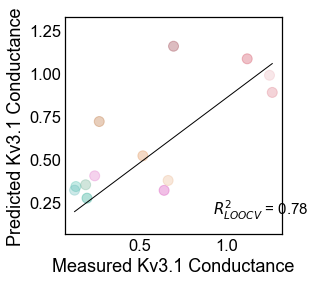

In [30]:
graph_pred(X_Kv3_1, y_Kv3_1, "Kv3.1")

In [15]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X = np.array(X_Kv3_1)
y = np.array(y_Kv3_1)
loo = LeaveOneOut()
loo.get_n_splits(X)
LeaveOneOut()
y_true, y_pred = list(), list()
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)
    model = LinearRegression()
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
# calculate accuracy
y_pred


TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [0]
[[ 6.62830179  6.41041762  2.46571886  1.91554669]
 [ 4.25332913  5.94837035  3.40366569  4.9412093 ]
 [ 2.2391683   0.33270019  2.03184643  5.41303703]
 [ 9.53932698  9.45476345  5.59494947  0.13212294]
 [ 9.61021556  9.77857597  6.09078535  0.36760015]
 [ 9.32100491 10.1534068   5.18260167  0.57504044]
 [ 9.39544886 10.69209193  5.94061087  1.00831389]
 [ 4.34595505  5.25113059  2.81364275  5.4419189 ]
 [ 2.21452021  3.00301611  2.54656001  4.88452309]
 [ 4.06403412  5.38314994  2.95618131  6.33285916]
 [ 4.25851256  6.24732657  3.51779146  4.91696008]
 [ 7.79761117  7.95938401  3.10472972  1.06099982]
 [ 7.12062811  8.63346487  2.70016199  4.40817897]
 [ 7.00516229  9.50537957  2.67939492  4.77580419]] [[6.46228829 4.48858409 1.7518829  1.76892532]] [0.63860379 0.12618228 0.14960082 0.69331171 1.12124592 1.26677179
 1.250779   0.19067592 0.12429393 0.11857144 0.18293929 0.26179661
 0.51526615 0.66189298] [0.23540195]
TRAIN

[0.40078821469887727,
 0.3164391451229097,
 0.33861193930503475,
 -0.3418357292554871,
 1.15359497653069,
 1.0805532091703847,
 0.8852434620355477,
 0.9849458673956107,
 0.2710662075400406,
 -0.1564741932023168,
 0.31755905490929204,
 0.3489546729974474,
 0.7162349011181302,
 0.5171080436320435,
 0.37385763046712983]

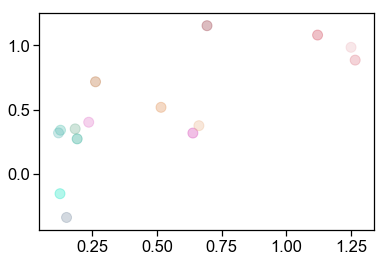

In [16]:
ax = plt
ax.scatter(y_true, y_pred, s = 100, alpha = 0.3, marker = 'o', c=list(shortened_palette.values()))